# Building Your Own Color Analysis Pipeline

## Introduction

In this project-based lesson, you'll build a **complete color analysis workflow** from scratch, combining all the techniques from previous lessons. By the end, you'll have a reusable pipeline that can analyze any artist or artwork.

### What You'll Build

A complete `ArtworkColorAnalyzer` class that:
1. Loads and filters artworks from WikiArt
2. Extracts color palettes using k-means clustering
3. Computes comprehensive color statistics
4. Detects color harmonies
5. Generates visualization reports
6. Exports results to various formats

### Learning Objectives

- Design a modular, reusable analysis pipeline
- Combine extraction, analysis, and visualization
- Handle errors gracefully
- Create exportable reports
- Apply software engineering best practices

Let's build!

## Setup

Import the base tools we'll build upon:

In [1]:
from renoir import ArtistAnalyzer
from renoir.color import ColorExtractor, ColorAnalyzer, ColorVisualizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import json
from typing import List, Dict, Optional, Tuple
from dataclasses import dataclass, asdict
import warnings
warnings.filterwarnings('ignore')

print("Imports complete!")

Imports complete!


## Part 1: Designing the Data Structures

Good software starts with good data structures. Let's define classes to hold our analysis results.

In [2]:
@dataclass
class ColorInfo:
    """Represents a single color with its properties."""
    rgb: Tuple[int, int, int]
    hex: str
    hue: float
    saturation: float
    value: float
    temperature: str  # 'warm', 'cool', or 'neutral'

@dataclass
class ArtworkAnalysis:
    """Analysis results for a single artwork."""
    title: str
    artist: str
    colors: List[ColorInfo]
    dominant_color: ColorInfo
    mean_hue: float
    mean_saturation: float
    mean_brightness: float
    color_diversity: float
    warm_percentage: float
    cool_percentage: float

@dataclass
class ArtistReport:
    """Complete analysis report for an artist."""
    artist_name: str
    num_works_analyzed: int
    total_colors_extracted: int
    artwork_analyses: List[ArtworkAnalysis]
    aggregate_stats: Dict
    harmony_analysis: Dict
    generated_at: str

print("Data structures defined!")
print("\nColorInfo fields:", [f.name for f in ColorInfo.__dataclass_fields__.values()])
print("ArtworkAnalysis fields:", [f.name for f in ArtworkAnalysis.__dataclass_fields__.values()])

Data structures defined!

ColorInfo fields: ['rgb', 'hex', 'hue', 'saturation', 'value', 'temperature']
ArtworkAnalysis fields: ['title', 'artist', 'colors', 'dominant_color', 'mean_hue', 'mean_saturation', 'mean_brightness', 'color_diversity', 'warm_percentage', 'cool_percentage']


## Part 2: Building the Pipeline Class

Now let's build the main `ArtworkColorAnalyzer` class step by step.

In [3]:
class ArtworkColorAnalyzer:
    """
    A complete color analysis pipeline for WikiArt artworks.
    
    This class provides methods to:
    - Load and filter artworks
    - Extract color palettes
    - Compute statistics
    - Generate reports and visualizations
    
    Example:
        >>> analyzer = ArtworkColorAnalyzer()
        >>> report = analyzer.analyze_artist('claude-monet', n_works=10)
        >>> analyzer.visualize_report(report)
    """
    
    def __init__(self, n_colors: int = 5, verbose: bool = True):
        """
        Initialize the analyzer.
        
        Args:
            n_colors: Number of dominant colors to extract per artwork
            verbose: Whether to print progress messages
        """
        self.n_colors = n_colors
        self.verbose = verbose
        
        # Initialize base analyzers
        self.artist_analyzer = ArtistAnalyzer()
        self.color_extractor = ColorExtractor()
        self.color_analyzer = ColorAnalyzer()
        self.visualizer = ColorVisualizer()
        
        # Cache for loaded dataset
        self._dataset = None
        
        if self.verbose:
            print("ArtworkColorAnalyzer initialized")
            print(f"  - Colors per artwork: {n_colors}")
    
    def _log(self, message: str):
        """Print message if verbose mode is on."""
        if self.verbose:
            print(message)
    
    @property
    def dataset(self):
        """Lazy-load the WikiArt dataset."""
        if self._dataset is None:
            self._log("Loading WikiArt dataset...")
            self._dataset = self.artist_analyzer.load_dataset()
            self._log(f"Dataset loaded: {len(self._dataset)} artworks")
        return self._dataset

# Test initialization
analyzer = ArtworkColorAnalyzer(n_colors=5)
print("\nAnalyzer ready!")

ArtworkColorAnalyzer initialized
  - Colors per artwork: 5

Analyzer ready!


### Step 2: Add Color Extraction Methods

In [4]:
# Add methods to the class (we'll rebuild the full class at the end)

def extract_color_info(self, rgb: Tuple[int, int, int]) -> ColorInfo:
    """
    Convert an RGB tuple to a ColorInfo object with all properties.
    
    Args:
        rgb: RGB color tuple (0-255 range)
    
    Returns:
        ColorInfo object with all color properties
    """
    hsv = self.color_analyzer.rgb_to_hsv(rgb)
    temperature = self.color_analyzer.classify_color_temperature(rgb)
    hex_color = self.color_extractor.rgb_to_hex(rgb)
    
    return ColorInfo(
        rgb=rgb,
        hex=hex_color,
        hue=hsv[0],
        saturation=hsv[1],
        value=hsv[2],
        temperature=temperature
    )

def analyze_single_artwork(self, artwork: Dict) -> Optional[ArtworkAnalysis]:
    """
    Perform complete color analysis on a single artwork.
    
    Args:
        artwork: Artwork dictionary from WikiArt dataset
    
    Returns:
        ArtworkAnalysis object, or None if analysis failed
    """
    try:
        # Extract dominant colors
        palette = self.color_extractor.extract_dominant_colors(
            artwork['image'], 
            n_colors=self.n_colors
        )
        
        # Convert to ColorInfo objects
        colors = [self.extract_color_info(rgb) for rgb in palette]
        
        # Compute statistics
        stats = self.color_analyzer.analyze_palette_statistics(palette)
        temp_dist = self.color_analyzer.analyze_color_temperature_distribution(palette)
        diversity = self.color_analyzer.calculate_color_diversity(palette)
        
        return ArtworkAnalysis(
            title=artwork.get('title', 'Untitled'),
            artist=artwork.get('artist', 'Unknown'),
            colors=colors,
            dominant_color=colors[0] if colors else None,
            mean_hue=stats['mean_hue'],
            mean_saturation=stats['mean_saturation'],
            mean_brightness=stats['mean_value'],
            color_diversity=diversity,
            warm_percentage=temp_dist['warm_percentage'],
            cool_percentage=temp_dist['cool_percentage']
        )
    except Exception as e:
        self._log(f"  Error analyzing artwork: {e}")
        return None

# Add to class
ArtworkColorAnalyzer.extract_color_info = extract_color_info
ArtworkColorAnalyzer.analyze_single_artwork = analyze_single_artwork

print("Color extraction methods added!")

Color extraction methods added!


### Step 3: Add Artist Analysis Method

In [5]:
def analyze_artist(self, artist_name: str, n_works: int = 10) -> ArtistReport:
    """
    Perform complete color analysis on an artist's works.
    
    Args:
        artist_name: Artist identifier (e.g., 'claude-monet')
        n_works: Number of works to analyze
    
    Returns:
        ArtistReport with complete analysis results
    """
    self._log(f"\n{'='*60}")
    self._log(f"Analyzing: {artist_name.replace('-', ' ').title()}")
    self._log(f"{'='*60}")
    
    # Get artist works
    works = self.artist_analyzer.extract_artist_works(artist_name, limit=n_works)
    self._log(f"Found {len(works)} works")
    
    if not works:
        return None
    
    # Analyze each artwork
    artwork_analyses = []
    all_colors = []
    
    for i, work in enumerate(works):
        self._log(f"  Analyzing work {i+1}/{len(works)}...")
        analysis = self.analyze_single_artwork(work)
        
        if analysis:
            artwork_analyses.append(analysis)
            all_colors.extend([c.rgb for c in analysis.colors])
    
    self._log(f"\nSuccessfully analyzed {len(artwork_analyses)} works")
    self._log(f"Total colors extracted: {len(all_colors)}")
    
    # Compute aggregate statistics
    aggregate_stats = {}
    if all_colors:
        stats = self.color_analyzer.analyze_palette_statistics(all_colors)
        temp_dist = self.color_analyzer.analyze_color_temperature_distribution(all_colors)
        
        aggregate_stats = {
            'mean_hue': stats['mean_hue'],
            'mean_saturation': stats['mean_saturation'],
            'mean_brightness': stats['mean_value'],
            'color_diversity': self.color_analyzer.calculate_color_diversity(all_colors),
            'saturation_score': self.color_analyzer.calculate_saturation_score(all_colors),
            'brightness_score': self.color_analyzer.calculate_brightness_score(all_colors),
            'warm_percentage': temp_dist['warm_percentage'],
            'cool_percentage': temp_dist['cool_percentage'],
            'neutral_percentage': temp_dist['neutral_percentage'],
            'dominant_temperature': temp_dist['dominant_temperature']
        }
    
    # Compute harmony analysis
    harmony_analysis = {}
    if all_colors:
        harmony_analysis = self.color_analyzer.analyze_color_harmony(all_colors)
    
    # Create report
    report = ArtistReport(
        artist_name=artist_name,
        num_works_analyzed=len(artwork_analyses),
        total_colors_extracted=len(all_colors),
        artwork_analyses=artwork_analyses,
        aggregate_stats=aggregate_stats,
        harmony_analysis=harmony_analysis,
        generated_at=datetime.now().isoformat()
    )
    
    self._log(f"\nReport generated at {report.generated_at}")
    
    return report

# Add to class
ArtworkColorAnalyzer.analyze_artist = analyze_artist

print("Artist analysis method added!")

Artist analysis method added!


### Step 4: Add Visualization Methods

In [6]:
def visualize_report(self, report: ArtistReport, save_path: Optional[str] = None):
    """
    Generate comprehensive visualizations for an artist report.
    
    Args:
        report: ArtistReport to visualize
        save_path: Optional path to save the figure
    """
    fig = plt.figure(figsize=(18, 12))
    
    artist_title = report.artist_name.replace('-', ' ').title()
    fig.suptitle(f"Color Analysis Report: {artist_title}", 
                 fontsize=20, fontweight='bold', y=1.02)
    
    # Collect all colors
    all_colors = []
    for analysis in report.artwork_analyses:
        all_colors.extend([c.rgb for c in analysis.colors])
    
    # 1. Color Palette (top row, full width)
    ax1 = fig.add_subplot(3, 3, (1, 3))
    sample_colors = all_colors[:40] if len(all_colors) > 40 else all_colors
    colors_norm = [(r/255, g/255, b/255) for r, g, b in sample_colors]
    
    for i, color in enumerate(colors_norm):
        ax1.add_patch(plt.Rectangle((i, 0), 1, 1, facecolor=color, edgecolor='white', lw=0.5))
    
    ax1.set_xlim(0, len(colors_norm))
    ax1.set_ylim(0, 1)
    ax1.axis('off')
    ax1.set_title(f'Extracted Color Palette ({len(all_colors)} colors)', fontsize=14, fontweight='bold')
    
    # 2. Temperature Distribution (pie chart)
    ax2 = fig.add_subplot(3, 3, 4)
    stats = report.aggregate_stats
    temps = [stats['warm_percentage'], stats['cool_percentage'], stats['neutral_percentage']]
    temp_labels = ['Warm', 'Cool', 'Neutral']
    temp_colors = ['#ff6b6b', '#4ecdc4', '#95a5a6']
    
    ax2.pie(temps, labels=temp_labels, colors=temp_colors, autopct='%1.1f%%',
            textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax2.set_title('Color Temperature Distribution', fontsize=12, fontweight='bold')
    
    # 3. Statistics Bar Chart
    ax3 = fig.add_subplot(3, 3, 5)
    stat_names = ['Saturation', 'Brightness', 'Diversity']
    stat_values = [
        stats['mean_saturation'],
        stats['mean_brightness'],
        stats['color_diversity'] * 100  # Scale to percentage
    ]
    bars = ax3.bar(stat_names, stat_values, color=['#9b59b6', '#f39c12', '#3498db'])
    ax3.set_ylabel('Value (%)')
    ax3.set_title('Color Statistics', fontsize=12, fontweight='bold')
    ax3.set_ylim(0, 100)
    for bar, val in zip(bars, stat_values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{val:.1f}', ha='center', fontweight='bold')
    
    # 4. Harmony Types
    ax4 = fig.add_subplot(3, 3, 6)
    harmony = report.harmony_analysis.get('harmony_counts', {})
    if harmony:
        h_names = [k.replace('_', ' ').title() for k in harmony.keys()]
        h_values = list(harmony.values())
        ax4.barh(h_names, h_values, color='#27ae60')
        ax4.set_xlabel('Count')
        ax4.set_title('Detected Harmonies', fontsize=12, fontweight='bold')
    
    # 5. Hue Distribution (polar plot)
    ax5 = fig.add_subplot(3, 3, 7, projection='polar')
    hues = []
    sats = []
    for analysis in report.artwork_analyses:
        for color in analysis.colors:
            hues.append(color.hue)
            sats.append(color.saturation)
    
    theta = np.radians(hues)
    r = [s/100 for s in sats]
    color_norm = [(c[0]/255, c[1]/255, c[2]/255) for c in all_colors]
    
    ax5.scatter(theta, r, c=color_norm[:len(theta)], s=50, alpha=0.6, edgecolors='black', lw=0.3)
    ax5.set_theta_zero_location('N')
    ax5.set_theta_direction(-1)
    ax5.set_title('Hue Distribution', fontsize=12, fontweight='bold', pad=20)
    
    # 6. Per-Artwork Comparison
    ax6 = fig.add_subplot(3, 3, 8)
    work_sats = [a.mean_saturation for a in report.artwork_analyses[:10]]
    work_brights = [a.mean_brightness for a in report.artwork_analyses[:10]]
    work_labels = [f"W{i+1}" for i in range(len(work_sats))]
    
    x = np.arange(len(work_labels))
    width = 0.35
    ax6.bar(x - width/2, work_sats, width, label='Saturation', color='#9b59b6')
    ax6.bar(x + width/2, work_brights, width, label='Brightness', color='#f39c12')
    ax6.set_xlabel('Artwork')
    ax6.set_ylabel('Value (%)')
    ax6.set_title('Per-Artwork Analysis', fontsize=12, fontweight='bold')
    ax6.set_xticks(x)
    ax6.set_xticklabels(work_labels)
    ax6.legend()
    
    # 7. Summary Text
    ax7 = fig.add_subplot(3, 3, 9)
    ax7.axis('off')
    summary_text = f"""
    ANALYSIS SUMMARY
    {'='*30}
    
    Works Analyzed: {report.num_works_analyzed}
    Colors Extracted: {report.total_colors_extracted}
    
    Dominant Temperature: {stats['dominant_temperature'].title()}
    Harmony Score: {report.harmony_analysis.get('harmony_score', 0):.2f}
    Dominant Harmony: {report.harmony_analysis.get('dominant_harmony', 'N/A').replace('_', ' ').title()}
    
    Generated: {report.generated_at[:10]}
    """
    ax7.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='#ecf0f1'))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        self._log(f"Figure saved to {save_path}")
    
    plt.show()

# Add to class
ArtworkColorAnalyzer.visualize_report = visualize_report

print("Visualization method added!")

Visualization method added!


### Step 5: Add Export Methods

In [7]:
def export_to_json(self, report: ArtistReport, filepath: str):
    """
    Export report to JSON format.
    
    Args:
        report: ArtistReport to export
        filepath: Path for the JSON file
    """
    # Convert dataclasses to dictionaries
    def convert_to_dict(obj):
        if hasattr(obj, '__dataclass_fields__'):
            return {k: convert_to_dict(v) for k, v in asdict(obj).items()}
        elif isinstance(obj, list):
            return [convert_to_dict(item) for item in obj]
        elif isinstance(obj, dict):
            return {k: convert_to_dict(v) for k, v in obj.items()}
        elif isinstance(obj, tuple):
            return list(obj)
        else:
            return obj
    
    data = convert_to_dict(report)
    
    with open(filepath, 'w') as f:
        json.dump(data, f, indent=2)
    
    self._log(f"Report exported to {filepath}")

def export_to_csv(self, report: ArtistReport, filepath: str):
    """
    Export artwork analyses to CSV format.
    
    Args:
        report: ArtistReport to export
        filepath: Path for the CSV file
    """
    rows = []
    for analysis in report.artwork_analyses:
        rows.append({
            'title': analysis.title,
            'artist': report.artist_name,
            'mean_hue': analysis.mean_hue,
            'mean_saturation': analysis.mean_saturation,
            'mean_brightness': analysis.mean_brightness,
            'color_diversity': analysis.color_diversity,
            'warm_percentage': analysis.warm_percentage,
            'cool_percentage': analysis.cool_percentage,
            'dominant_color_hex': analysis.dominant_color.hex if analysis.dominant_color else None,
            'num_colors': len(analysis.colors)
        })
    
    df = pd.DataFrame(rows)
    df.to_csv(filepath, index=False)
    
    self._log(f"Data exported to {filepath}")

def print_summary(self, report: ArtistReport):
    """
    Print a text summary of the report.
    
    Args:
        report: ArtistReport to summarize
    """
    stats = report.aggregate_stats
    harmony = report.harmony_analysis
    
    print("\n" + "="*60)
    print(f"ARTIST COLOR ANALYSIS REPORT")
    print(f"{'='*60}")
    print(f"\nArtist: {report.artist_name.replace('-', ' ').title()}")
    print(f"Generated: {report.generated_at}")
    print(f"\n{'─'*40}")
    print(f"OVERVIEW")
    print(f"{'─'*40}")
    print(f"Works Analyzed: {report.num_works_analyzed}")
    print(f"Colors Extracted: {report.total_colors_extracted}")
    print(f"\n{'─'*40}")
    print(f"COLOR STATISTICS")
    print(f"{'─'*40}")
    print(f"Mean Hue: {stats['mean_hue']:.1f}°")
    print(f"Mean Saturation: {stats['mean_saturation']:.1f}%")
    print(f"Mean Brightness: {stats['mean_brightness']:.1f}%")
    print(f"Color Diversity: {stats['color_diversity']:.2f}")
    print(f"\n{'─'*40}")
    print(f"TEMPERATURE")
    print(f"{'─'*40}")
    print(f"Warm: {stats['warm_percentage']:.1f}%")
    print(f"Cool: {stats['cool_percentage']:.1f}%")
    print(f"Neutral: {stats['neutral_percentage']:.1f}%")
    print(f"Dominant: {stats['dominant_temperature'].title()}")
    print(f"\n{'─'*40}")
    print(f"HARMONY")
    print(f"{'─'*40}")
    print(f"Harmony Score: {harmony.get('harmony_score', 0):.2f}")
    print(f"Dominant Type: {harmony.get('dominant_harmony', 'N/A').replace('_', ' ').title()}")
    print(f"Total Harmonies: {harmony.get('total_harmonies', 0)}")
    print(f"\n{'='*60}")

# Add to class
ArtworkColorAnalyzer.export_to_json = export_to_json
ArtworkColorAnalyzer.export_to_csv = export_to_csv
ArtworkColorAnalyzer.print_summary = print_summary

print("Export methods added!")

Export methods added!


## Part 3: Using the Pipeline

Now let's use our complete pipeline to analyze an artist!

In [8]:
# Create the analyzer
analyzer = ArtworkColorAnalyzer(n_colors=5, verbose=True)

# Analyze an artist
report = analyzer.analyze_artist('claude-monet', n_works=10)

ArtworkColorAnalyzer initialized
  - Colors per artwork: 5

Analyzing: Claude Monet
Loading WikiArt dataset...


Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/45 [00:00<?, ?it/s]

✓ Loaded 81444 artworks
✓ Found 10 works by claude-monet
Found 10 works
  Analyzing work 1/10...
  Analyzing work 2/10...
  Analyzing work 3/10...
  Analyzing work 4/10...
  Analyzing work 5/10...
  Analyzing work 6/10...
  Analyzing work 7/10...
  Analyzing work 8/10...
  Analyzing work 9/10...
  Analyzing work 10/10...

Successfully analyzed 10 works
Total colors extracted: 50

Report generated at 2025-11-24T13:01:56.862052


In [9]:
# Print text summary
analyzer.print_summary(report)


ARTIST COLOR ANALYSIS REPORT

Artist: Claude Monet
Generated: 2025-11-24T13:01:56.862052

────────────────────────────────────────
OVERVIEW
────────────────────────────────────────
Works Analyzed: 10
Colors Extracted: 50

────────────────────────────────────────
COLOR STATISTICS
────────────────────────────────────────
Mean Hue: 67.7°
Mean Saturation: 27.6%
Mean Brightness: 55.9%
Color Diversity: 0.85

────────────────────────────────────────
TEMPERATURE
────────────────────────────────────────
Warm: 38.0%
Cool: 30.0%
Neutral: 32.0%
Dominant: Warm

────────────────────────────────────────
HARMONY
────────────────────────────────────────
Harmony Score: 1.00
Dominant Type: Tetradic
Total Harmonies: 38837



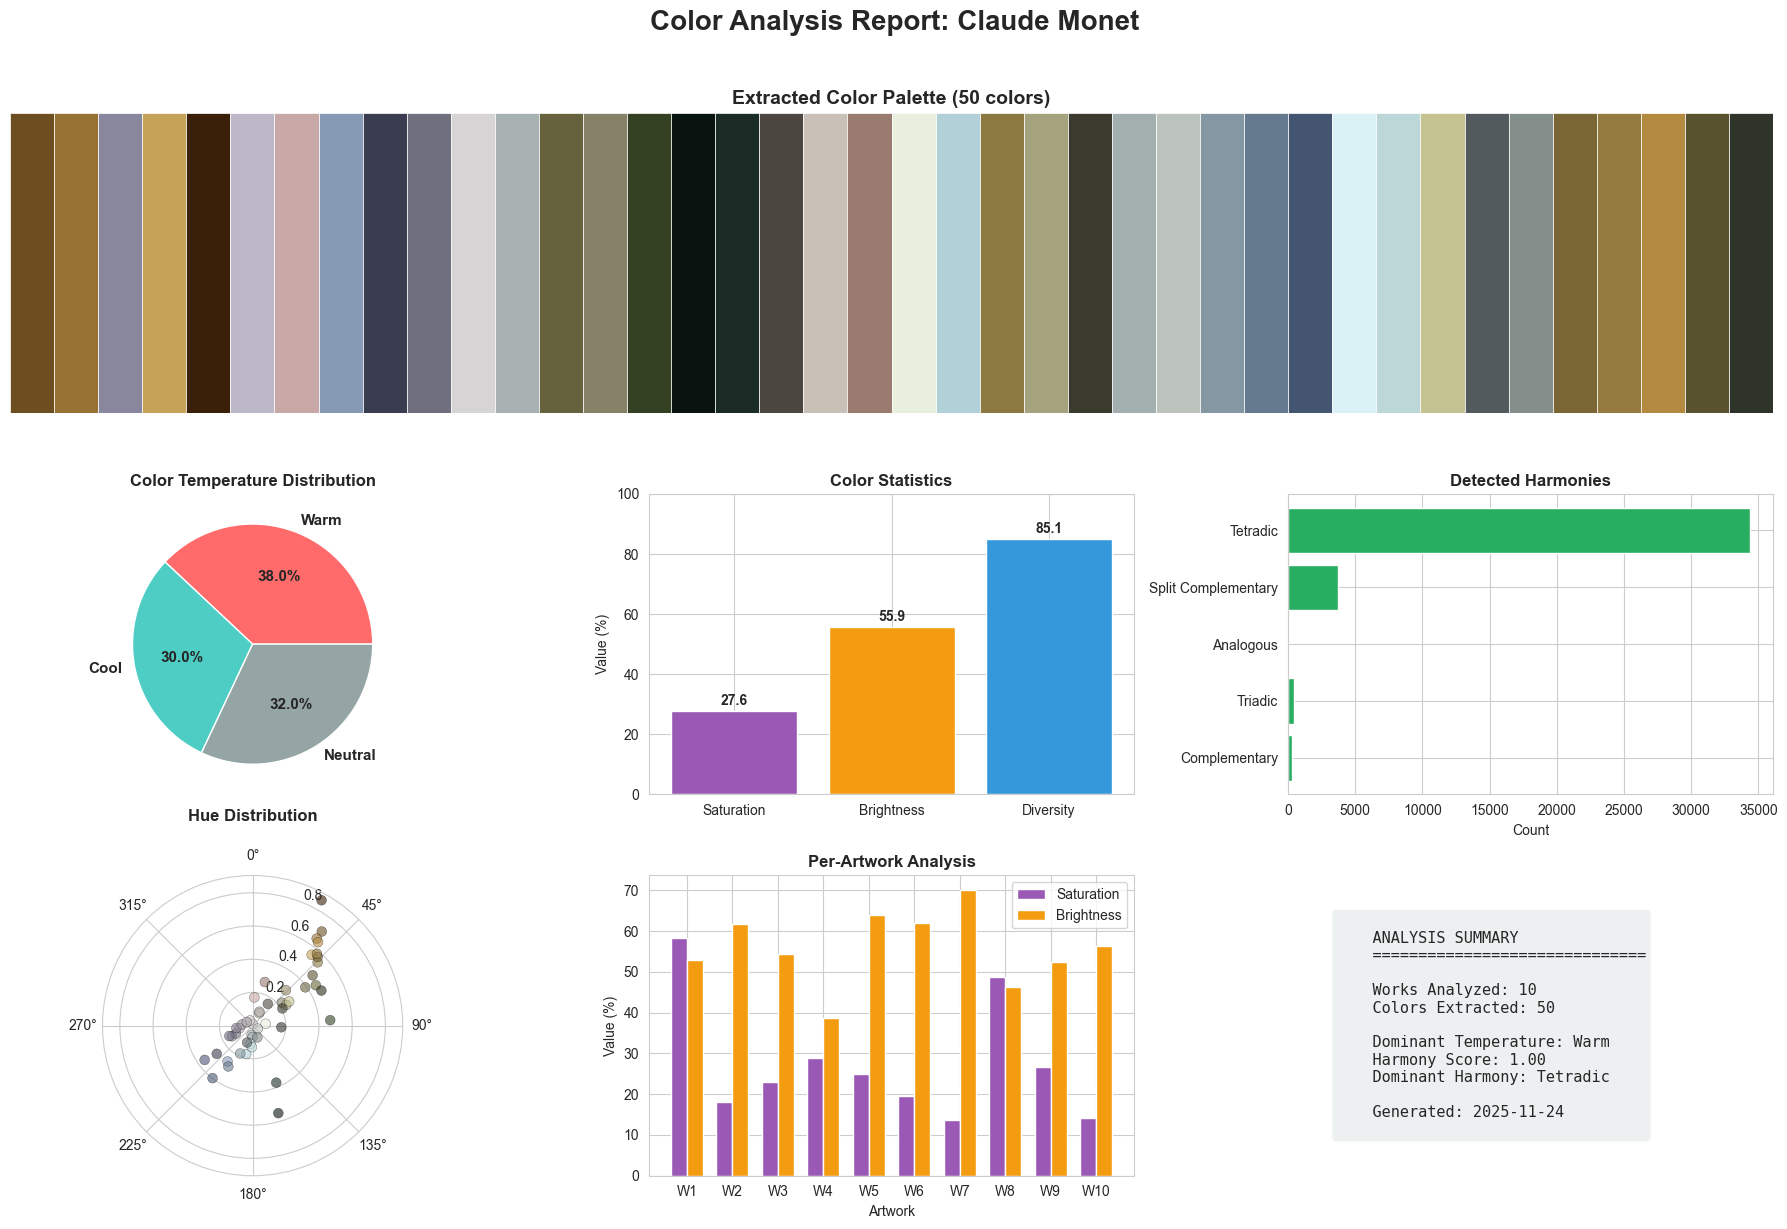

In [10]:
# Generate visual report
analyzer.visualize_report(report)

## Part 4: Comparing Multiple Artists

Let's extend our pipeline to compare multiple artists.

In [11]:
def compare_artists(self, artist_names: List[str], n_works: int = 10) -> pd.DataFrame:
    """
    Compare color statistics across multiple artists.
    
    Args:
        artist_names: List of artist identifiers
        n_works: Number of works to analyze per artist
    
    Returns:
        DataFrame with comparison statistics
    """
    results = []
    
    for artist in artist_names:
        report = self.analyze_artist(artist, n_works)
        
        if report and report.aggregate_stats:
            stats = report.aggregate_stats
            results.append({
                'Artist': artist.replace('-', ' ').title(),
                'Works': report.num_works_analyzed,
                'Mean Hue': stats['mean_hue'],
                'Saturation': stats['mean_saturation'],
                'Brightness': stats['mean_brightness'],
                'Diversity': stats['color_diversity'],
                'Warm %': stats['warm_percentage'],
                'Cool %': stats['cool_percentage'],
                'Dominant Temp': stats['dominant_temperature'].title()
            })
    
    return pd.DataFrame(results)

# Add to class
ArtworkColorAnalyzer.compare_artists = compare_artists

# Compare three artists
comparison = analyzer.compare_artists([
    'claude-monet',
    'vincent-van-gogh',
    'pierre-auguste-renoir'
], n_works=8)

print("\n" + "="*80)
print("ARTIST COMPARISON")
print("="*80)
print(comparison.to_string(index=False))


Analyzing: Claude Monet
✓ Found 8 works by claude-monet
Found 8 works
  Analyzing work 1/8...
  Analyzing work 2/8...
  Analyzing work 3/8...
  Analyzing work 4/8...
  Analyzing work 5/8...
  Analyzing work 6/8...
  Analyzing work 7/8...
  Analyzing work 8/8...

Successfully analyzed 8 works
Total colors extracted: 40

Report generated at 2025-11-24T13:02:23.017877

Analyzing: Vincent Van Gogh
✓ Found 8 works by vincent-van-gogh
Found 8 works
  Analyzing work 1/8...
  Analyzing work 2/8...
  Analyzing work 3/8...
  Analyzing work 4/8...
  Analyzing work 5/8...
  Analyzing work 6/8...
  Analyzing work 7/8...
  Analyzing work 8/8...

Successfully analyzed 8 works
Total colors extracted: 40

Report generated at 2025-11-24T13:02:24.811916

Analyzing: Pierre Auguste Renoir
✓ Found 8 works by pierre-auguste-renoir
Found 8 works
  Analyzing work 1/8...
  Analyzing work 2/8...
  Analyzing work 3/8...
  Analyzing work 4/8...
  Analyzing work 5/8...
  Analyzing work 6/8...
  Analyzing work 7/8.

## Part 5: Exercise - Extend the Pipeline

Now it's your turn! Extend the pipeline with new features.

In [ ]:
# EXERCISE 1: Add a method to find the most colorful artwork
# Hint: Use color_diversity to rank artworks

def find_most_colorful(self, report: ArtistReport) -> ArtworkAnalysis:
    """Find the artwork with highest color diversity."""
    # YOUR CODE HERE
    pass

# EXERCISE 2: Add a method to filter artworks by temperature
# Hint: Filter based on warm_percentage or cool_percentage

def filter_by_temperature(self, report: ArtistReport, temp: str, threshold: float = 50) -> List[ArtworkAnalysis]:
    """Get artworks that are predominantly warm or cool."""
    # YOUR CODE HERE
    pass

# EXERCISE 3: Add a method to generate a color palette recommendation
# Hint: Extract the most common colors across all artworks

def recommend_palette(self, report: ArtistReport, n_colors: int = 5) -> List[ColorInfo]:
    """Recommend a palette based on the artist's most used colors."""
    # YOUR CODE HERE
    pass

---

## Conclusion

Congratulations! You've built a complete color analysis pipeline that:

1. **Loads** artwork data from WikiArt
2. **Extracts** dominant colors using k-means clustering
3. **Analyzes** color statistics, temperature, and harmony
4. **Visualizes** results with comprehensive charts
5. **Exports** data to JSON and CSV formats
6. **Compares** multiple artists side by side

### Key Software Engineering Concepts Applied

- **Data Classes**: Structured data representation
- **Modular Design**: Separate methods for each task
- **Error Handling**: Graceful failure on problematic artworks
- **Lazy Loading**: Dataset loaded only when needed
- **Type Hints**: Clear function signatures
- **Documentation**: Docstrings for all methods

### Next Steps

- Add caching to speed up repeated analyses
- Implement parallel processing for faster batch analysis
- Add more visualization options
- Build a command-line interface
- Create a web dashboard with the results